In [ ]:
# Imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset , DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 5
learning_rate = 0.01

In [ ]:
# Load Data
train_data = torchvision.datasets.MNIST(root = '/data', train = True, download = True , transform = transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root = '/data', train = False, download = False, transform = transforms.ToTensor())

train_loader = DataLoader(train_data , batch_size = batch_size , shuffle=True)
test_loader = DataLoader(test_data , batch_size = batch_size , shuffle=False )

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw


Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw


Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# LSTM class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
total_step = len(train_loader)
all_loss = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    all_loss.append(epoch_loss /10)    

Epoch [1/5], Step [100/600], Loss: 0.5564
Epoch [1/5], Step [200/600], Loss: 0.1142
Epoch [1/5], Step [300/600], Loss: 0.1758
Epoch [1/5], Step [400/600], Loss: 0.1686
Epoch [1/5], Step [500/600], Loss: 0.0597
Epoch [1/5], Step [600/600], Loss: 0.0423
Epoch [2/5], Step [100/600], Loss: 0.0331
Epoch [2/5], Step [200/600], Loss: 0.0773
Epoch [2/5], Step [300/600], Loss: 0.1330
Epoch [2/5], Step [400/600], Loss: 0.0826
Epoch [2/5], Step [500/600], Loss: 0.1474
Epoch [2/5], Step [600/600], Loss: 0.1452
Epoch [3/5], Step [100/600], Loss: 0.0918
Epoch [3/5], Step [200/600], Loss: 0.0714
Epoch [3/5], Step [300/600], Loss: 0.0358
Epoch [3/5], Step [400/600], Loss: 0.0612
Epoch [3/5], Step [500/600], Loss: 0.0688
Epoch [3/5], Step [600/600], Loss: 0.0431
Epoch [4/5], Step [100/600], Loss: 0.1632
Epoch [4/5], Step [200/600], Loss: 0.0600
Epoch [4/5], Step [300/600], Loss: 0.0482
Epoch [4/5], Step [400/600], Loss: 0.0164
Epoch [4/5], Step [500/600], Loss: 0.0482
Epoch [4/5], Step [600/600], Loss:

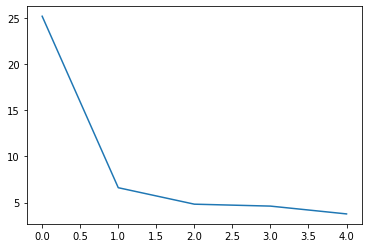

In [ ]:
plt.plot(range(5) , all_loss)

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on the 10000 test images: 98.26 %
